<a href="https://colab.research.google.com/github/AleksandrRevuka/HW_Data_Science/blob/main/Hw8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [4]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [19]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=128)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=128, out_features=256)
    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=256, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)

    return self.layer_3(x, activation=1)

In [20]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    predicteda_classes = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(predicteda_classes, tf.cast(y_true, tf.int64))
    accuracy =  tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy

In [21]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients  = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

  acc = accuracy(pred, output_y)

  return loss, acc

In [22]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss, acc = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        current_accuracy = accuracy(pred, batch_y)

        # Зберігаємо історію втрат та точності
        loss_history.append(current_loss)
        accuracy_history.append(current_accuracy)

        # Виводимо інформацію про поточний етап навчання
        print(f"Step {step}/{training_steps}, Loss: {current_loss}, Accuracy: {current_accuracy}")


Step 100/3000, Loss: 356.519775390625, Accuracy: 0.64453125
Step 200/3000, Loss: 238.80319213867188, Accuracy: 0.75390625
Step 300/3000, Loss: 171.79827880859375, Accuracy: 0.80859375
Step 400/3000, Loss: 152.19602966308594, Accuracy: 0.83984375
Step 500/3000, Loss: 133.5432586669922, Accuracy: 0.86328125
Step 600/3000, Loss: 133.13076782226562, Accuracy: 0.85546875
Step 700/3000, Loss: 124.34042358398438, Accuracy: 0.875
Step 800/3000, Loss: 107.10427856445312, Accuracy: 0.8671875
Step 900/3000, Loss: 112.50933837890625, Accuracy: 0.85546875
Step 1000/3000, Loss: 135.90982055664062, Accuracy: 0.8671875
Step 1100/3000, Loss: 81.08937072753906, Accuracy: 0.8984375
Step 1200/3000, Loss: 85.81320190429688, Accuracy: 0.890625
Step 1300/3000, Loss: 86.87659454345703, Accuracy: 0.90625
Step 1400/3000, Loss: 83.25404357910156, Accuracy: 0.921875
Step 1500/3000, Loss: 95.06983947753906, Accuracy: 0.90625
Step 1600/3000, Loss: 61.96228790283203, Accuracy: 0.93359375
Step 1700/3000, Loss: 57.022

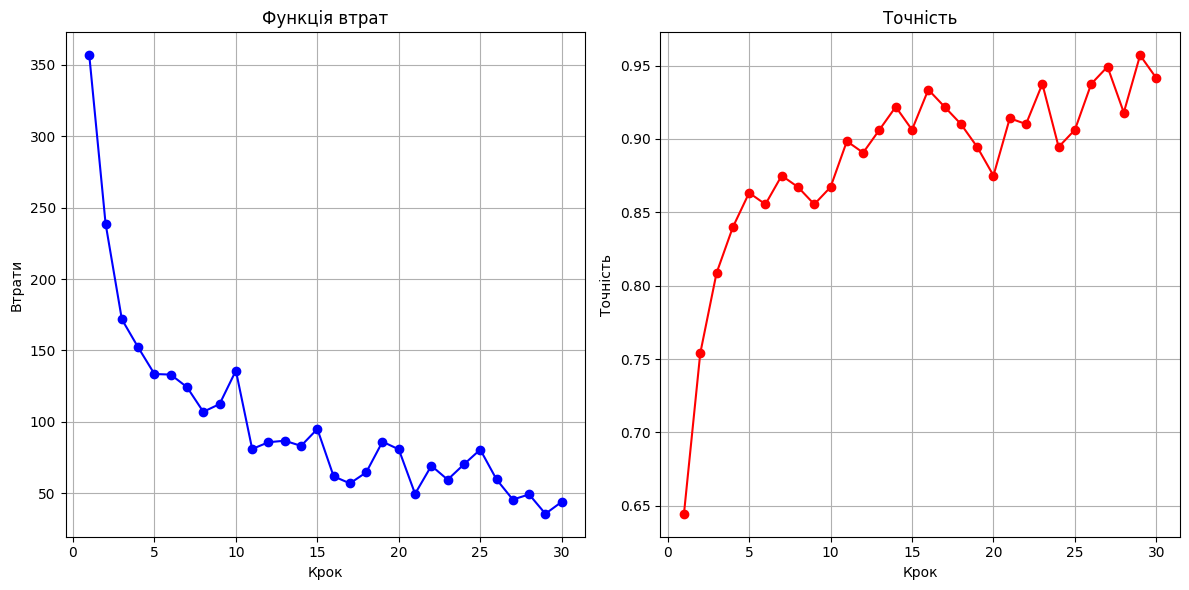

In [26]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-', color='b')
plt.title('Функція втрат')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.grid(True)

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', linestyle='-', color='r')
plt.title('Точність')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.grid(True)

plt.tight_layout()
plt.show()


In [27]:
# Обчисліть точність навченої нейромережі
# Тестування моделі на тестових даних
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size)

test_accuracy = 0
for batch_x, batch_y in test_data:
    pred = neural_net(batch_x)
    test_accuracy += accuracy(pred, batch_y)

test_accuracy /= len(test_data)

print(f"Точність на тестових даних: {test_accuracy.numpy()}")

Точність на тестових даних: 0.904589831829071


In [ ]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду




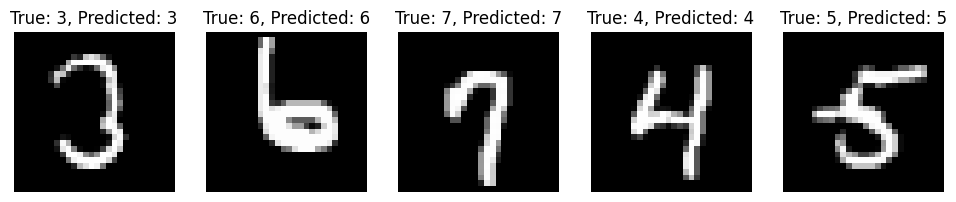

In [30]:
# Випадково виберіть 5 зображень з тестового набору
random_indices = np.random.choice(len(x_test), size=5, replace=False)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]

# Передайте зображення нейромережі та зробіть передбачення
predictions = neural_net(images_to_test)
predicted_labels = np.argmax(predictions, axis=1)

# Виведення зображень та передбачень
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_to_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {labels_to_test[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')

plt.show()